# Libraries Used

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import re
import datetime
#pd.set_option('display.max_columns', 60)
from sklearn.impute import SimpleImputer
import glob
import os
from wordcloud import WordCloud

# 1. Understand Data

In [4]:
#read the csv file and get the number of rows and columns of data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [153]:
all_files = glob.glob(os.path.join("*.csv"))    
all_data_frame = []
row_count = 0
for file in all_files:
    data_frame = pd.read_csv(file)
    all_data_frame.append(data_frame)
    # axis=0纵向合并 axis=1横向合并
df_data = pd.concat(all_data_frame, axis=0, ignore_index=True, sort=True)

In [154]:
df_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


In [155]:
print("There are {} rows and {} columns in the dataset."
      .format(df_data.shape[0], df_data.shape[1]))

There are 10000 rows and 13 columns in the dataset.


In [156]:
#descriptive statistics of data
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                9994 non-null   object 
 1   description            10000 non-null  object 
 2   designation            7171 non-null   object 
 3   points                 10000 non-null  int64  
 4   price                  9323 non-null   float64
 5   province               9994 non-null   object 
 6   region_1               8336 non-null   object 
 7   region_2               3853 non-null   object 
 8   taster_name            8015 non-null   object 
 9   taster_twitter_handle  7644 non-null   object 
 10  title                  10000 non-null  object 
 11  variety                10000 non-null  object 
 12  winery                 10000 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1015.8+ KB


In [157]:
df_data.describe()

,points,price
count,10000.000000,9323.000000
mean,88.460000,35.447603
std,3.030003,40.898626
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


In [158]:
#This function is used to calculate the number and proportion of 
#null values in each column

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent],axis=1) #make a table

    mis_re = mis_val_table.rename(
        columns={0: 'Number of Missing Values', 1: 'proportion of Missing Values(%)'})
    mis_sort = (mis_re[mis_re.iloc[:, 1] != 0].sort_values(
        'proportion of Missing Values(%)', ascending=False).round(1))

    return mis_sort

In [159]:
#check the missing values and 
#drop all features with null values more than 50% and
#drop samples with null target ('points')
missing_values_table(df_data)

,Number of Missing Values,proportion of Missing Values(%)
region_2,6147,61.5
designation,2829,28.3
taster_twitter_handle,2356,23.6
taster_name,1985,19.8
region_1,1664,16.6
price,677,6.8
country,6,0.1
province,6,0.1


In [160]:
# calculate the number of unique values of each categorical feature

ca_columns = (df_data.select_dtypes(include="object").columns)
for column in ca_columns:
    print("{} has {} different values.".format(column, df_data[column].nunique()))


country has 37 different values.
description has 9942 different values.
designation has 5381 different values.
province has 248 different values.
region_1 has 724 different values.
region_2 has 17 different values.
taster_name has 18 different values.
taster_twitter_handle has 14 different values.
title has 9930 different values.
variety has 333 different values.
winery has 5460 different values.


In [161]:
# Unique values of taster_name and taster_twitter_handle are nearly the same

taster_names = df_data["taster_name"].unique()
for value in taster_names:
    print(value)

Kerin O’Keefe
Roger Voss
nan
Virginie Boone
Anna Lee C. Iijima
Sean P. Sullivan
Lauren Buzzeo
Joe Czerwinski
Michael Schachner
Paul Gregutt
Jim Gordon
Matt Kettmann
Anne Krebiehl MW
Susan Kostrzewa
Jeff Jenssen
Carrie Dykes
Mike DeSimone
Alexander Peartree
Fiona Adams


In [162]:
taster_twitter_handles = (df_data["taster_twitter_handle"].unique())
for value in taster_twitter_handles:
    print(value)

@kerinokeefe
@vossroger
nan
@vboone
@wawinereport
@laurbuzz
@JoeCz
@wineschach
@paulgwine 
@gordone_cellars
@mattkettmann
@AnneInVino
@suskostrzewa
@worldwineguys
@bkfiona


# 2.Clean Data

In [163]:
# this function drops not used features:
        #(high cardinality:designation, winery)
        #(high-percentage missing value features: region_2)
        #(dependent features: taster_twitter_handle)
# and duplicate rows
# and empty rows of target('points')


def CleanData(df):
    drop_columns = ["designation",
                    "winery",
                    "region_2",
                    "taster_twitter_handle"]
    
    inclean_df = df.drop(columns=drop_columns)
    inclean_df2 = (inclean_df.drop_duplicates(ignore_index=True))
    cleaned_df = (inclean_df2.dropna(subset=["points"], how="any").reset_index(drop=True))
    
    return cleaned_df

In [164]:
df_cleaned = CleanData(df_data)

In [165]:
# Transform the points to classes
  #There is no sample in range(94,98)

def points_to_class(points):
    if points in range(80,83):
        return int(0)
    elif points in range(83,87):
        return int(1)
    elif points in range(87,90):
        return int(2)
    elif points in range(90,94):
        return int(3)
    else:
        return int(4)

In [166]:
df_cleaned["rating"] = df_cleaned["points"].apply(points_to_class)

# 3. Exploratory Data Analysis

/Users/jiangruobing/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of points'}, xlabel='points', ylabel='Count'>

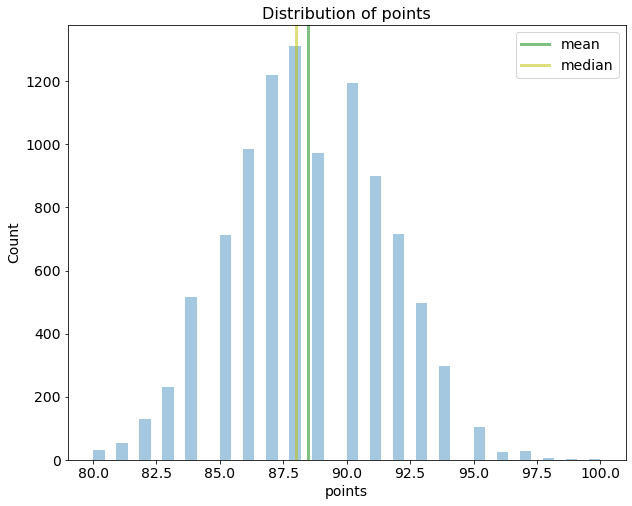

In [185]:
# show the distribution of points


#define a function to print histogram with line of mean and median

def plot_histogram(df, column):
    
    # set the histogram, mean and median
    g = sns.distplot(df[column],
                     kde=False,
                     bins=None)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column),
               size=14)
    plt.ylabel("Count",
               size=14)
    plt.title("Distribution of {}".format(column),
              size=16)
    plt.legend(["mean", "median"])

    return g

plot_histogram(df_cleaned, "points")

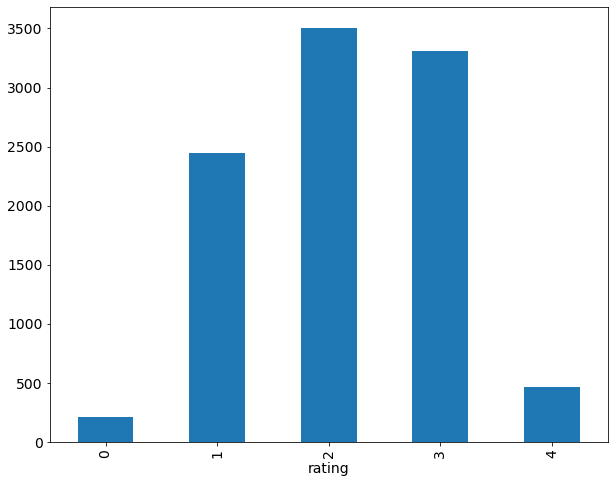

In [186]:
#show the distribution of ratings

df_cleaned.groupby('rating').size().plot(kind='bar') 
plt.show()

<AxesSubplot:title={'center':'Distribution of price'}, xlabel='price', ylabel='Count'>

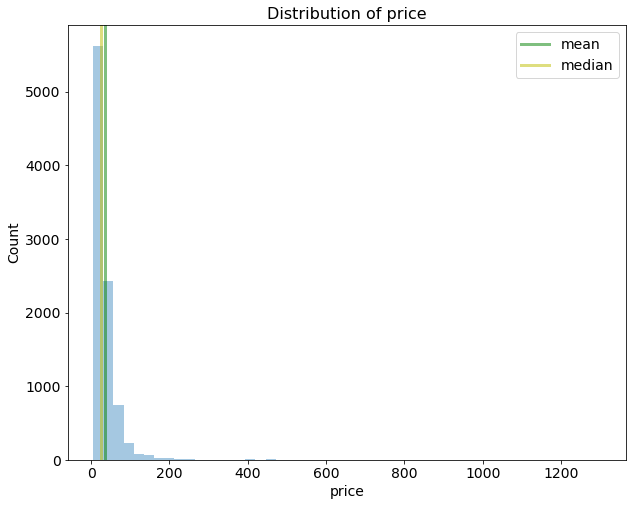

In [187]:
# distribution of price

plot_histogram(df_cleaned, "price")

(0.0, 200.0)

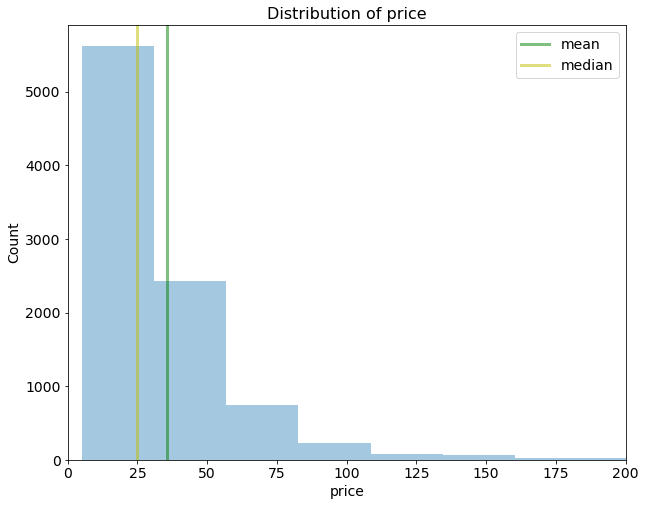

In [188]:
# distribution of price in the range(0,200)

plot_histogram(df_cleaned, "price")
plt.xlim(0,200)

In [190]:
# points VS countries

# for understandable plots wines from 
# themost frequent countries' points
# will be visualized

countries = (train_cleaned["country"]
             .value_counts())

freq_countries = list(
    countries[
        countries.values > 300]
    .index)

freq2_countries = list(
    countries[
        (countries.values <= 300) &
        (countries.values >= 100)]
    .index)

In [213]:
def plot_distribution(df, target, column_values, column_name):
    # funtion to print distribution of a continuous variable
    # for categorical data

    for value in column_values:
        subset = df[
            df[column_name] == value]
        g = sns.kdeplot(subset[target],
                        label=value,
                        linewidth=3)

    # set title, legends and labels
    plt.ylabel("Density",
               size=14)
    plt.xlabel("{}".format(target),
               size=14)
    plt.title("Distribution of {} per {}"
              .format(target, column_name),
              size=16)
    plt.legend([i for i in column_values])

    return g

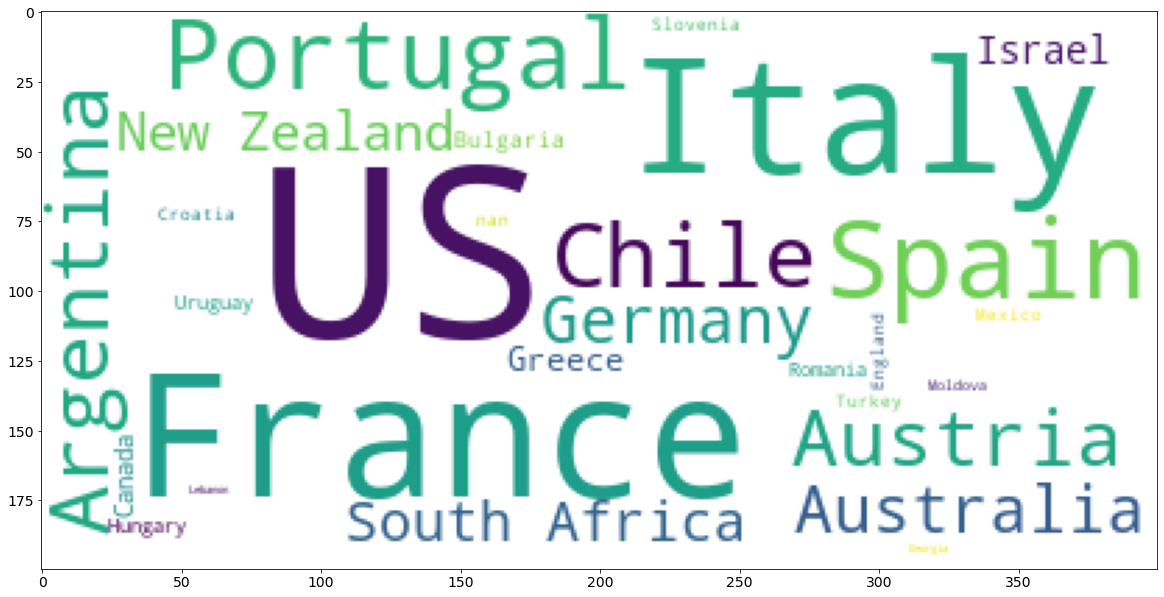

In [208]:
# word cloud of countries
#countries = df_cleaned[df_cleaned['Analysis']=='Negative']
country_list=df_cleaned['country'].to_list()
country_words=' '.join(str(i) for i in country_list)
#country_words=" ".join(country_list)
plt.figure(figsize=(20,20))

plt.imshow(WordCloud(background_color=(255,255,255)).generate(country_words))

<AxesSubplot:title={'center':'Distribution of points per country'}, xlabel='points', ylabel='Density'>

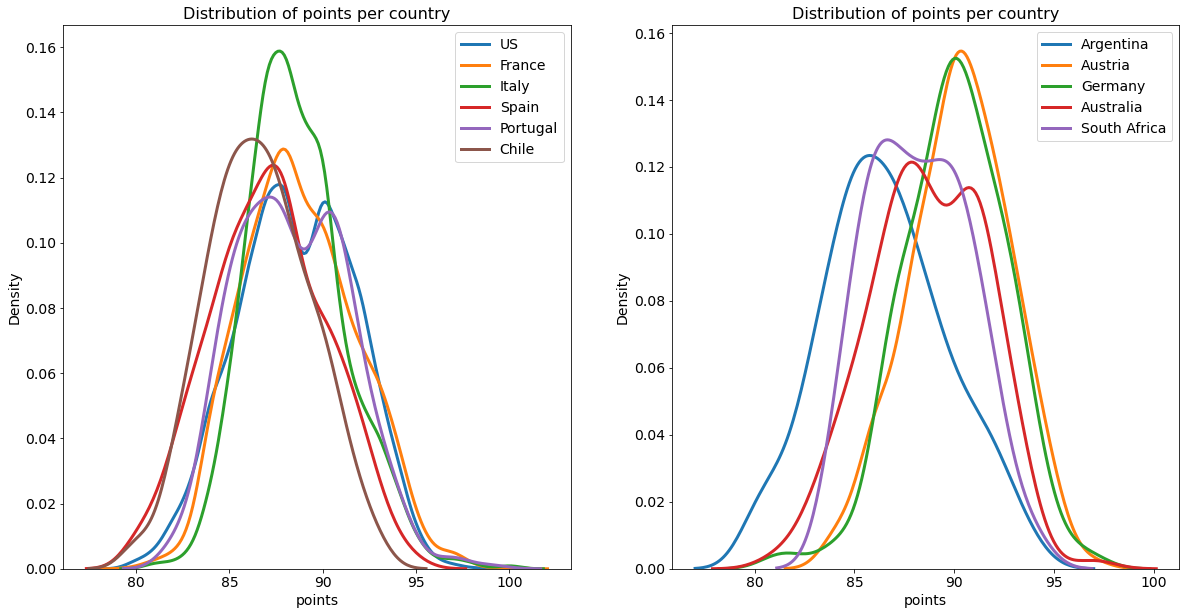

In [214]:
# distribution of the points per country
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for most frequent countries
plt.subplot(1, 2, 1)
plot_distribution(df_cleaned, "points",
                  freq_countries, "country")

# plot points distribution for second most frequent countries
plt.subplot(1, 2, 2)
plot_distribution(df_cleaned, "points",
                  freq2_countries, "country")

In [191]:
# points VS price

# to select most frequent countries
points_freq_countries = df_cleaned[df_cleaned.country.isin(freq_countries)]

(0.0, 200.0)

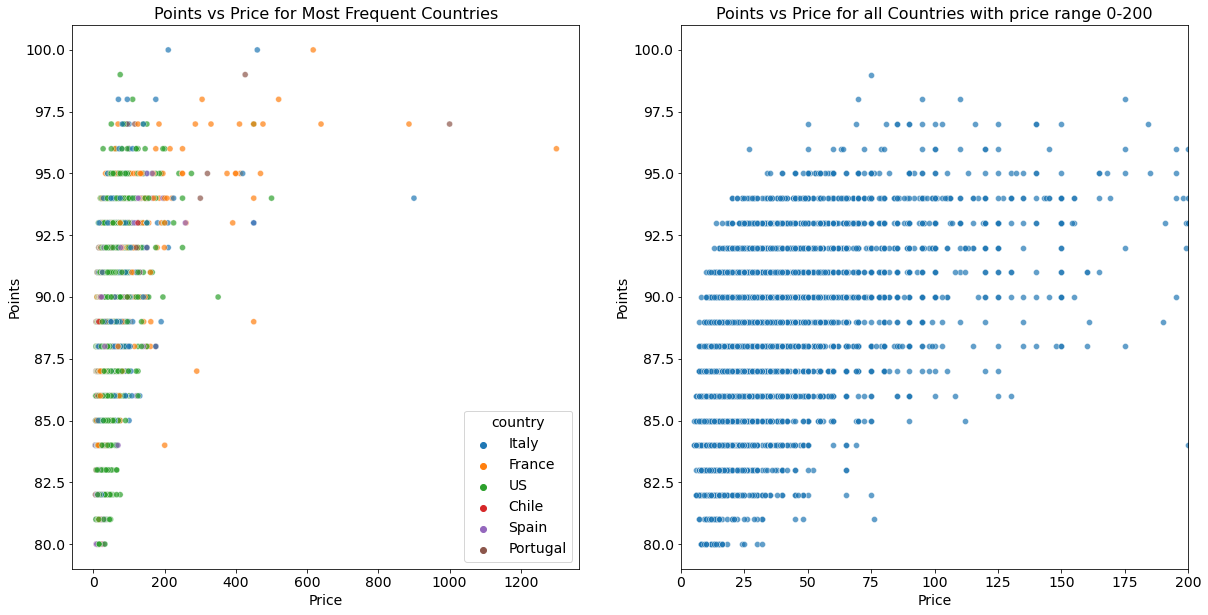

In [195]:
# set plot size and font size
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot a scatterplot of Points and Price
plt.subplot(1,2,1)
sns.scatterplot(x='price', y='points',
                hue='country', 
                data=points_freq_countries,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for Most Frequent Countries", 
          size=16)


# plot a scatterplot of Points and Price
plt.subplot(1,2,2)
sns.scatterplot(x='price', y='points', 
                data=train_cleaned,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for all Countries with price range 0-200", 
          size=16)
plt.xlim(0,200)

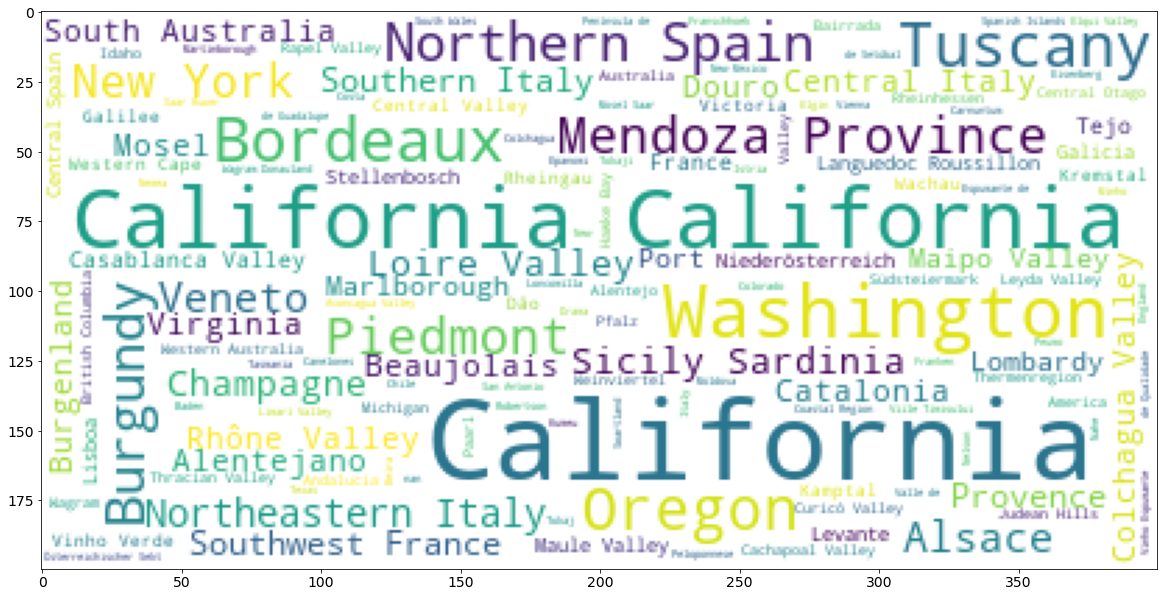

In [209]:
# word cloud of provinces

province_list=df_cleaned['province'].to_list()
province_words=' '.join(str(i) for i in province_list)

plt.figure(figsize=(20,20))

plt.imshow(WordCloud(background_color=(255,255,255)).generate(province_words))

In [197]:
def create_province_list(df, country_name):
    # funtion to create list of provinces
    # for a given country name
    indexed_train = df.set_index("country")
    province_list = list(
        indexed_train
        .loc[country_name]["province"]
        .unique())
    return province_list

In [198]:
# Points VS province in most frequent countries

# make lists of provinces
provinces_us = create_province_list(
    df_cleaned, "US")
provinces_fr = create_province_list(
    df_cleaned, "France")
provinces_it = create_province_list(
    df_cleaned, "Italy")
provinces_es = create_province_list(
    df_cleaned, "Spain")

/Users/jiangruobing/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jiangruobing/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jiangruobing/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jiangruobing/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:title={'center':'Distribution of points per province'}, xlabel='points', ylabel='Density'>

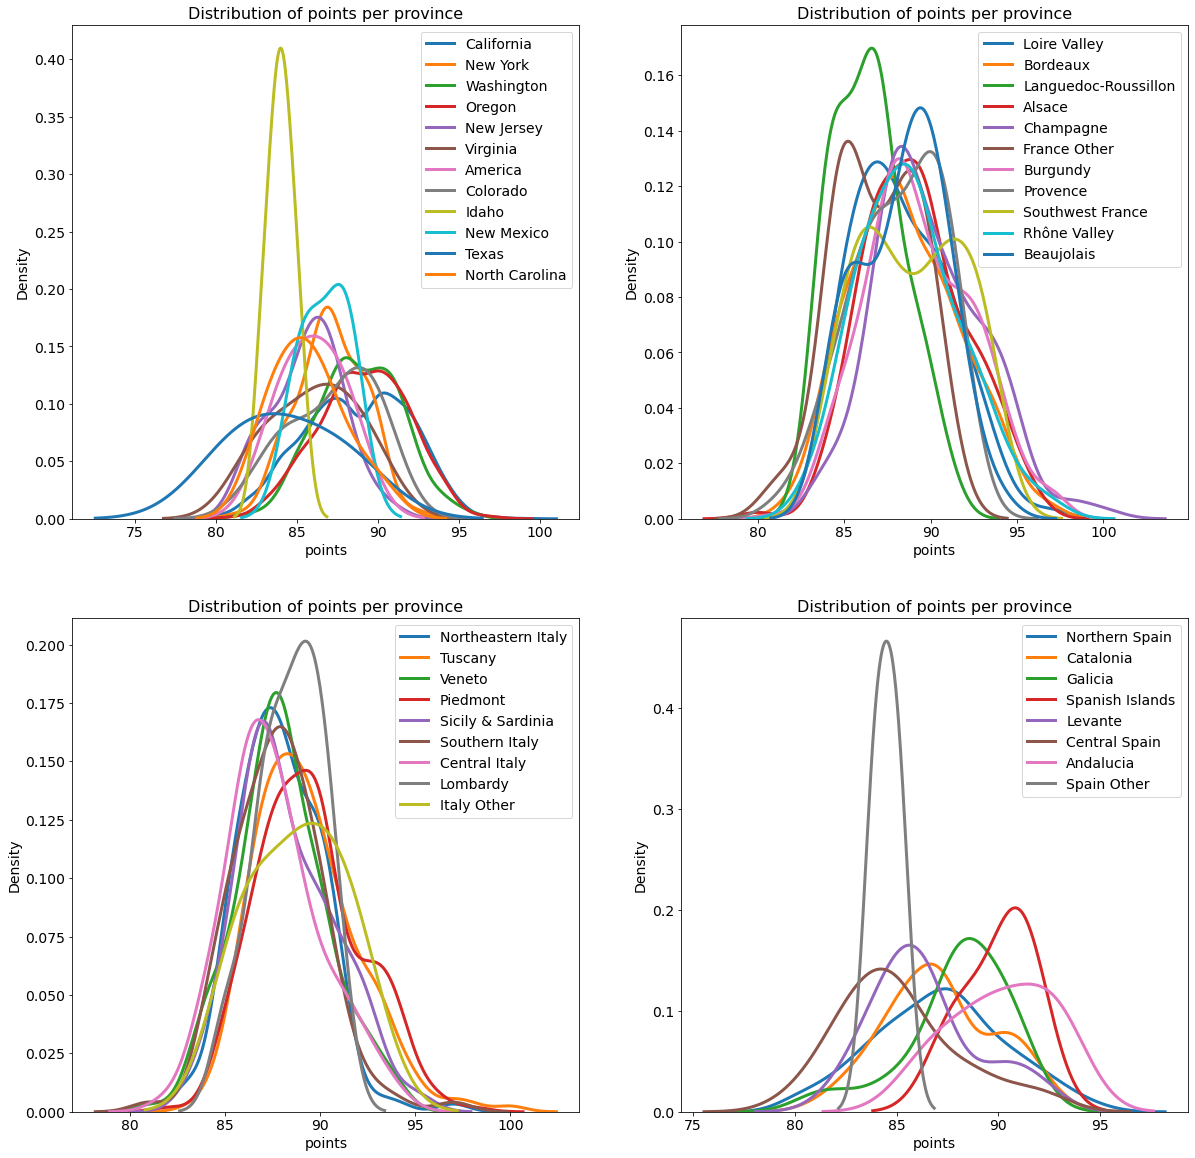

In [215]:
# distribution of provinces
figsize(20, 20)
plt.rcParams['font.size'] = 14

# plot points distribution for provinces
plt.subplot(2,2,1)
plot_distribution(train_cleaned, "points", 
                  provinces_us, "province")

# plot points distribution for provinces
plt.subplot(2,2,2)
plot_distribution(train_cleaned, "points", 
                  provinces_fr, "province")

# plot points distribution for provinces
plt.subplot(2,2,3)
plot_distribution(train_cleaned, "points", 
                  provinces_it, "province")

# plot points distribution for provinces
plt.subplot(2,2,4)
plot_distribution(train_cleaned, "points", 
                  provinces_es, "province")

Text(0.5, 1.0, 'Points from Different Tasters')

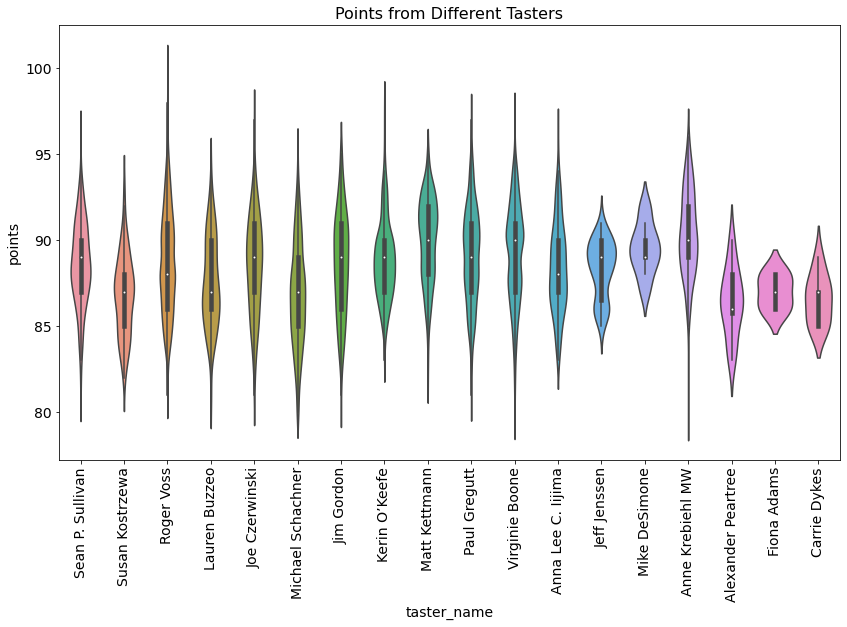

In [200]:
# Points VS taster_name

# set plot size and font size
figsize(14, 8)
plt.rcParams['font.size'] = 14

# violin plot to see descriptive statistics 
# and distribution
# per taster_name
f = sns.violinplot(data=train_cleaned,
                   x="taster_name",
                   y="points")

f.set_xticklabels(f.get_xticklabels(),
                  rotation=90)

plt.title("Points from Different Tasters",
          size=16)

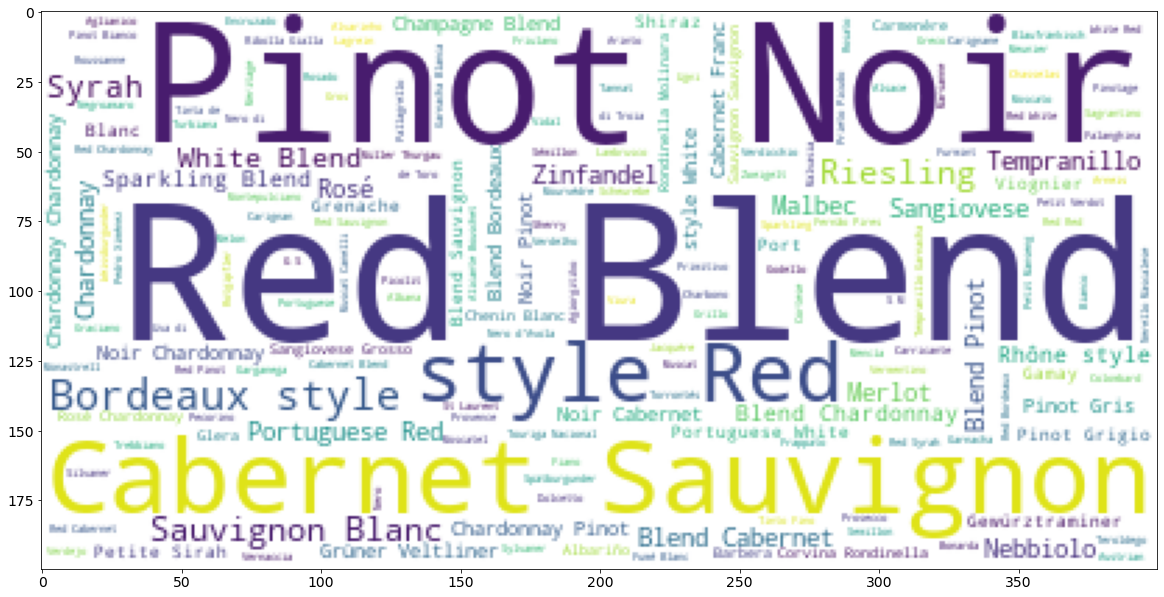

In [210]:
# word cloud of varieties

variety_list=df_cleaned['variety'].to_list()
variety_words=' '.join(str(i) for i in variety_list)

plt.figure(figsize=(20,20))

plt.imshow(WordCloud(background_color=(255,255,255)).generate(variety_words))

In [201]:
# Points VS variety

# make list of most-appearing varieties
varieties = (train_cleaned["variety"]
             .value_counts())

freq_varieties = list(
    varieties[
        varieties.values > 200]
    .index)

freq2_varieties = list(
    varieties[
        (varieties.values <= 200) & 
        (varieties.values >= 100)]
    .index)

<AxesSubplot:title={'center':'Distribution of points per variety'}, xlabel='points', ylabel='Density'>

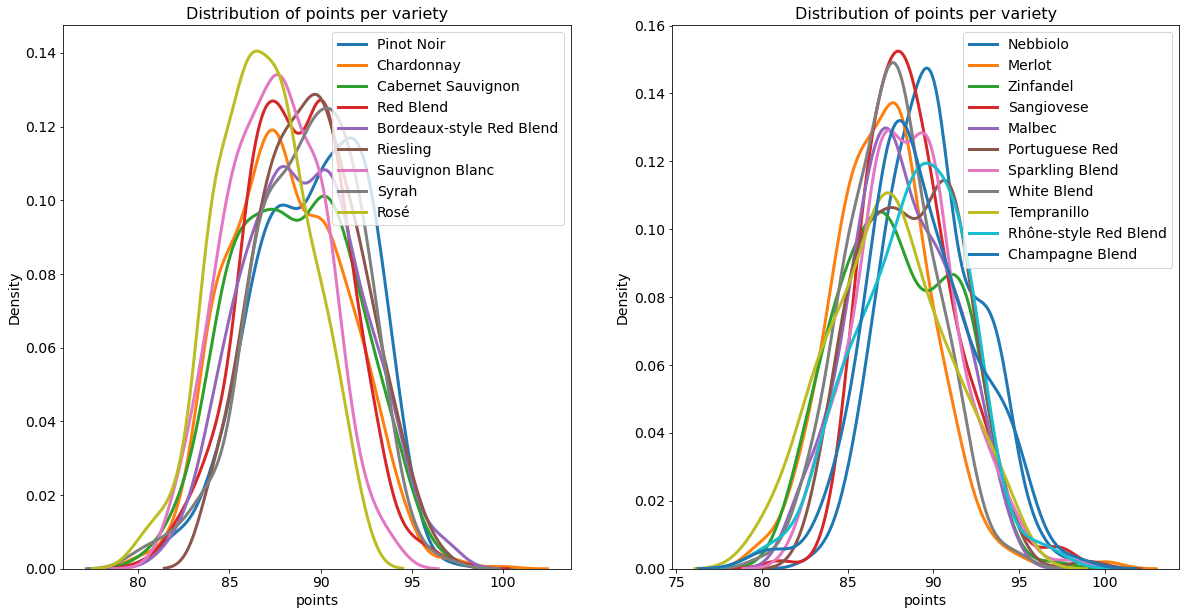

In [216]:
# distribution of the points per variety
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for frequent varieties
plt.subplot(1,2,1)
plot_distribution(train_cleaned, "points", 
                  freq_varieties, "variety")

# plot points distribution for second most frequent varieties
plt.subplot(1,2,2)
plot_distribution(train_cleaned, "points", 
                  freq2_varieties, "variety")

# 4. Feature Extraction

In [167]:
# define a function to extract information from 'description'

def extract_features_from_description(df, new_feature_name, extract_words):
    
    check_regex = (r'\b(?:{})\b'
                   .format('|'
                           .join(
                               map(re.escape,
                                   extract_words))))

    df[new_feature_name] = (df['description']
                            .str
                            .contains(check_regex,
                                      regex=True)
                            .astype('uint8'))
    return df

In [168]:
# from title
def extract_year_from_title(title):
    # function to find the year in the given list
    # if not found assigns zero as year
    # ASSUMPTION: There is no NA values
    # in the title feature
    
    int_list = []
    now = datetime.datetime.now()
    
    for item in title:
        int_list.append(int(item))
    
    for item in int_list:
        if item <= now.year and item >= 1900:
            return item
        else:
            return 0

In [169]:
# from variety
def extract_blend_from_variety(variety):
    # function to find if a variety is a blend
    # ASSUMPTION: There is no NA values
    # in the variety feature
    
    if (variety.find("-") != -1) | (variety.find("Blend") != -1):
        if variety == "Xarel-lo":
            return 0
        else:
            return 1
    else:
        return 0

In [170]:
# create search terms for new features 
# to be extracted from description
is_red_list = ["red", "Red", "RED",
               "noir", "NOIR", "Noir",
               "black", "BLACK", "Black"]

is_white_list = ["white", "WHITE", "White",
                 "blanc", "Blanc", "BLANC",
                 "bianco", "Bianco", "BIANCO",
                 "blanco", "Blanco", "BLANCO",
                 "blanca", "Blanca", "BLANCA"]

is_rose_list = ["rose", "ROSE", "Rose",
                "rosé", "Rosé", "ROSÉ"]

is_sparkling_list = ["sparkling", "SPARKLING", "Sparkling"]

is_dry_list = ["dry", "Dry", "DRY",
               "dried", "Dried", "DRIED"]

is_sweet_list = ["sweet", "Sweet", "SWEET"]

desc_extracting_dict = {
    "is_red": is_red_list,
    "is_white": is_white_list,
    "is_rose": is_rose_list,
    "is_sparkling": is_sparkling_list,
    "is_dry": is_dry_list,
    "is_sweet": is_sweet_list
}

In [171]:
def ExtractFeatures(df):
    # adds is_red, is_white, is_rose, is_rose
    # is_sparkling, is_dry, is_sweet
    for key, value in desc_extracting_dict.items():
        interim_df = extract_features_from_description(
            df, key, value)

    # adds year
    interim_df["title_numlist"] = (interim_df
                                   .title
                                   .str
                                   .findall(r'\b\d+\b'))

    interim_df["year"] = (interim_df
                          .title_numlist
                          .apply(extract_year_from_title))

    # adds is_blend
    interim_df["is_blend"] = (interim_df
                              .variety
                              .apply(extract_blend_from_variety))
    # drops unused features
    features_added_df = (interim_df
                         .drop(columns=["description",
                                        "title",
                                        "title_numlist"]))
    return features_added_df

In [172]:
features_added = ExtractFeatures(df_cleaned)

In [173]:
features_added.head(10)

,country,points,price,province,region_1,taster_name,variety,rating,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,Italy,90,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Sauvignon,3,0,0,0,0,0,0,2012.0,0
1,France,87,22.0,Loire Valley,Sancerre,Roger Voss,Rosé,2,1,0,0,0,0,0,2014.0,0
2,Italy,86,NaN,Tuscany,Chianti Classico,NaN,Sangiovese,1,1,0,0,0,0,0,2009.0,0
3,US,92,50.0,California,Russian River Valley,Virginie Boone,Pinot Noir,3,1,0,1,0,0,0,2012.0,0
4,US,93,38.0,California,Russian River Valley,Virginie Boone,Chardonnay,3,0,0,0,0,0,0,2013.0,0
5,US,84,14.0,California,Dry Creek Valley,NaN,Chardonnay,1,0,0,0,0,0,0,2012.0,0
6,US,87,25.0,New York,North Fork of Long Island,Anna Lee C. Iijima,Gewürztraminer,2,0,0,0,0,1,0,2013.0,0
7,US,84,35.0,California,Paso Robles,NaN,Barbera,1,0,0,0,0,1,0,2007.0,0
8,France,94,NaN,Bordeaux,Sauternes,Roger Voss,Bordeaux-style White Blend,4,0,0,0,0,0,0,2009.0,1
9,France,88,12.0,Bordeaux,Bordeaux Blanc,Roger Voss,Bordeaux-style White Blend,2,0,1,0,0,0,0,2014.0,1


In [174]:
# missing value imputation

# imputate the null year & price with median
yearprice_df = pd.DataFrame(features_added[["price", "year"]])
    
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(yearprice_df)

imputed_set = median_imputer.transform(yearprice_df)
imputed_year_price_df = pd.DataFrame(imputed_set,columns=yearprice_df.columns)



In [176]:
imputed_year_price_df.head()

,price,year
0,30.0,2012.0
1,22.0,2014.0
2,25.0,2009.0
3,50.0,2012.0
4,38.0,2013.0


In [178]:
# imputate the null tastername & country & province & region_1 with mode

tcpr_df = pd.DataFrame(train_features_added[["taster_name", "country", "province", "region_1"]])
#test_df = pd.DataFrame(test_features_added[["taster_name", "country", "province", "region_1"]]) 
    
most_frequent_imputer = SimpleImputer(strategy="most_frequent")
most_frequent_imputer.fit(tcpr_df)
    
imputed_set = most_frequent_imputer.transform(tcpr_df)
imputed_tas_cou_pro_reg_df = pd.DataFrame(imputed_set,columns=tcpr_df.columns)

#imputed_test_set = most_frequent_imputer.transform(test_df)
#imtest_tas_cou_pro_reg_df = pd.DataFrame(imputed_test_set,columns=test_df.columns)

In [179]:
imputed_tas_cou_pro_reg_df.head()

,taster_name,country,province,region_1
0,Sean P. Sullivan,US,Washington,Columbia Valley (WA)
1,Susan Kostrzewa,South Africa,Stellenbosch,Napa Valley
2,Roger Voss,Portugal,Douro,Napa Valley
3,Lauren Buzzeo,South Africa,Stellenbosch,Napa Valley
4,Roger Voss,Portugal,Dão,Napa Valley


In [180]:
# create a dataframe to store the extracted is_features

isfeatures = features_added[[col for col in features_added if col.find("is_") != -1]]
#test_isfeatures = test_features_added[[col for col in test_features_added if col.find("is_") != -1]]
isfeatures

,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,is_blend
0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
9937,1,0,0,0,0,0,0
9938,1,0,0,0,0,0,0
9939,0,0,1,0,1,0,0
9940,0,0,0,0,0,0,0


In [181]:
features_target = (pd.DataFrame(features_added,columns=['variety'])
                      .join(imputed_year_price_df)
                      .join(imputed_tas_cou_pro_reg_df)
                      .join(isfeatures)
                      .join(pd.DataFrame(features_added,columns=['rating'])))

#train_target = pd.DataFrame(train_features_added["rating"])

#test_features_target = (pd.DataFrame(test_features_added,columns=['variety'])
#                      .join(imtest_year_price_df)
#                      .join(imtest_tas_cou_pro_reg_df)
#                      .join(test_isfeatures)
#                      .join(pd.DataFrame(test_features_added,columns=['rating'])))
#test_target = pd.DataFrame(test_features_added["rating"])

In [182]:
features_target.head()

,variety,price,year,taster_name,country,province,region_1,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,is_blend,rating
0,Sauvignon,30.0,2012.0,Sean P. Sullivan,US,Washington,Columbia Valley (WA),0,0,0,0,0,0,0,3
1,Rosé,22.0,2014.0,Susan Kostrzewa,South Africa,Stellenbosch,Napa Valley,1,0,0,0,0,0,0,2
2,Sangiovese,25.0,2009.0,Roger Voss,Portugal,Douro,Napa Valley,1,0,0,0,0,0,0,1
3,Pinot Noir,50.0,2012.0,Lauren Buzzeo,South Africa,Stellenbosch,Napa Valley,1,0,1,0,0,0,0,3
4,Chardonnay,38.0,2013.0,Roger Voss,Portugal,Dão,Napa Valley,0,0,0,0,0,0,0,3
